In [1]:
import numpy as np
from numpy import sqrt
from scipy.special import wofz
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import argrelmax, savgol_filter
from scipy.interpolate import UnivariateSpline

In [2]:
def gaussian_absorption(x, amp, center, sigma, offset):
    return offset - amp * np.exp(-(x - center)**2 / (2 * sigma**2))

def voigt_absorption(x, amp, center, sigma, gamma, offset):
    z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
    voigt_prof = np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))
    voigt_norm = voigt_prof / np.max(voigt_prof)
    return offset - amp * voigt_norm

def normalize_continuum(wavelength, flux, flux_error=None, poly_order=3, exclude_regions=None, plot=False):
    mask = np.ones_like(wavelength, dtype=bool)
    if exclude_regions is not None:
        for region in exclude_regions:
            mask &= ~((wavelength > region[0]) & (wavelength < region[1]))

    poly_coeffs = np.polyfit(wavelength[mask], flux[mask], deg=poly_order)
    continuum = np.polyval(poly_coeffs, wavelength)
    norm_flux = flux / continuum
    norm_flux_error = flux_error / continuum if flux_error is not None else None

    if plot:
        # Plot normalization
        plt.figure()
        plt.plot(wavelength, flux, label="Original Flux")
        plt.plot(wavelength, continuum, label="Fitted Continuum", linestyle="--")
        if exclude_regions is not None:
            for region in exclude_regions:
                plt.axvspan(region[0], region[1], color='red', alpha=0.2)
        plt.legend()
        plt.title("Continuum Normalization")
        plt.xlabel("Wavelength [Å]")
        plt.ylabel("Flux")
        plt.tight_layout()
        plt.show()

    return norm_flux, norm_flux_error, continuum

def iterative_polyfit(wavelength, flux, flux_error=None, degree=3, sigma=2, max_iter=5, plot=False):
    mask = np.ones_like(wavelength, dtype=bool)
    for _ in range(max_iter):
        coeffs = np.polyfit(wavelength[mask], flux[mask], degree)
        model = np.polyval(coeffs, wavelength)
        residuals = flux - model
        std = np.std(residuals[mask])
        mask &= np.abs(residuals) < sigma * std

    continuum = np.polyval(coeffs, wavelength)
    norm_flux = flux / continuum
    norm_flux_error = flux_error / continuum if flux_error is not None else None

    if plot:
        # Plot normalization
        plt.figure()
        plt.plot(wavelength, flux, label="Original Flux")
        plt.plot(wavelength, continuum, label="Fitted Continuum", linestyle="--")
        plt.legend()
        plt.title("Continuum Normalization")
        plt.xlabel("Wavelength [Å]")
        plt.ylabel("Flux")
        plt.tight_layout()
        plt.show()

    return norm_flux, norm_flux_error, continuum

def envelope_spline_fit(wavelength, flux, flux_error=None, exclude_regions=None, smoothing=51, spline_s=1e5, plot=False):
    # Initial full mask
    mask = np.ones_like(wavelength, dtype=bool)
    if exclude_regions is not None:
        for region in exclude_regions:
            mask &= ~((wavelength > region[0]) & (wavelength < region[1]))

    # Smooth flux to suppress noise
    smooth_flux = savgol_filter(flux, window_length=smoothing, polyorder=3)

    # Find local maxima in smoothed flux
    peaks = argrelmax(smooth_flux, order=20)[0]
    peak_mask = mask[peaks]  # exclude masked regions
    peak_wavelengths = wavelength[peaks][peak_mask]
    # Replace this line:
    # peak_fluxes = flux[peaks][peak_mask]

    # With this:
    peak_fluxes = smooth_flux[peaks][peak_mask]


    # Spline fit through the selected peaks
    spline = UnivariateSpline(peak_wavelengths, peak_fluxes, s=spline_s)
    continuum = spline(wavelength)

    # Normalize
    norm_flux = flux / continuum
    norm_flux_error = flux_error / continuum if flux_error is not None else None

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(wavelength, flux, label='Original Flux')
        plt.plot(wavelength, continuum, '--', label='Fitted Continuum', color='orange')
        plt.scatter(peak_wavelengths, peak_fluxes, s=10, color='green', label='Used Peaks')
        if exclude_regions:
            for r in exclude_regions:
                plt.axvspan(r[0], r[1], color='red', alpha=0.2)
        plt.xlabel('Wavelength [Å]')
        plt.ylabel('Flux')
        plt.title('Continuum Fit with Upper Envelope Spline')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return norm_flux, norm_flux_error, continuum




In [3]:
def fit_centroid(wavelength, flux, flux_error=None, lambda_0=None, w1=None, w2=None, line_name=None, plot=False):
    exclude_regions = [
    (3865, 3930),   # H + K
    (4060, 4140),   # Hδ
    (4290, 4407),   # Hγ
    (4790, 4950),   # Hβ (shortened)
    ]
    #norm_flux, norm_flux_error, continuum = normalize_continuum(
        #wavelength, flux, flux_error=flux_error, poly_order=2, exclude_regions=exclude_regions, plot=should_plot
        #)
    #norm_flux, norm_flux_error, continuum = iterative_polyfit(
        #wavelength, flux, flux_error=flux_error, degree=3, sigma=2, max_iter=5, plot=should_plot
        #)
    norm_flux, norm_flux_error, continuum = envelope_spline_fit(
        wavelength, flux, flux_error=flux_error,
        exclude_regions=exclude_regions,
        smoothing=51,
        spline_s=5e4,
        plot=should_plot
        )   

    #plt.plot(wavelength, norm_flux)
    #plt.show()
    # Then apply mask :)
    mask = (wavelength > w1) & (wavelength < w2)
    x = wavelength[mask]
    y = norm_flux[mask]
    if flux_error is not None:
        yerr = norm_flux_error[mask]
    else:
        yerr = None

    # Smooth to estimate approximate line center
    y_smoothed = gaussian_filter1d(y, sigma=2)
    center_guess = x[np.argmin(y_smoothed)]

    #offset_guess = np.median(y[(x < center_guess - 1.5) | (x > center_guess + 1.5)])
    #amp_guess = offset_guess - np.min(y)
    #sigma_guess = 30.0

    #p0 = [amp_guess, center_guess, sigma_guess, offset_guess]
    #amp_max = offset_guess * 2.0
    #lower = [0.0, center_guess - 5.0, 25.0, offset_guess - 1.0]
    #upper = [amp_max, center_guess + 5.0, 35.0, offset_guess + 1.0]

    # Initial guess for Voigt
    gamma_guess = 35.0  # Lorentzian width guess
    offset_region = ((wavelength > w1) & (wavelength < (w1 + 15))) | ((wavelength > (w2 - 15)) & (wavelength < w2))
    offset_guess = np.median(norm_flux[offset_region])
    amp_guess = offset_guess - np.min(y)
    amp_guess = np.clip(offset_guess - np.min(y), 0.01, 3.0)
    sigma_guess = 20.0

    p0 = [amp_guess, center_guess, sigma_guess, gamma_guess, offset_guess]
    lower = [0.0, center_guess - 3.0, 10.0, 30.0, offset_guess - 0.2]
    upper = [3.0, center_guess + 3.0, 40.0, 40.0, offset_guess + 0.2]
    
    yerr_mod = yerr.copy()
    core = (x > center_guess - 1.0) & (x < center_guess + 1.0)
    yerr_mod[core] *= 1.1  # Less influence in core


    try:
        #popt, pcov = curve_fit(gaussian_absorption, x, y, p0=p0, bounds=(lower, upper), sigma=yerr)
        #popt, pcov = curve_fit(gaussian_absorption, x, y, p0=p0, bounds=(lower, upper), sigma=yerr_mod)
        #popt, pcov = curve_fit(voigt_absorption, x, y, p0=p0, bounds=(lower, upper), sigma=yerr)
        popt, pcov = curve_fit(voigt_absorption, x, y, p0=p0, bounds=(lower, upper), sigma=yerr_mod)
        center = popt[1]
        center_err = sqrt(pcov[1, 1]) if pcov is not None else np.nan
        print(f"Fit center = {center:.4f} ± {center_err:.4f} Å")
        velocity = 3e5 * (center - lambda_0) / lambda_0
        velocity_err = 3e5 * center_err / lambda_0
        #print(f"{velocity=}")
        #print(f"{velocity_err=}")
        #Diagnostic plot
        if plot:
            plt.figure(figsize=(10, 5))
            plt.errorbar(x, y, yerr=yerr, fmt='k.', ecolor='gray', capsize=2, label='Observed Spectrum')
            #plt.plot(x, gaussian_absorption(x, *popt), 'r-', label='Gaussian Fit')
            plt.plot(x, voigt_absorption(x, *popt), 'r-', label='Voigt Fit')
            plt.axvline(lambda_0, color='blue', linestyle=':', label=f'Reference Value: {lambda_0:.2f} Å')
            plt.axvline(popt[1], color='red', linestyle='--', label=f'Fit Center: {popt[1]:.2f} Å')
            plt.text(0.05, 0.05, f"Radial velocity estimate and error: {velocity:.2f}, {velocity_err:.2f}", fontsize=12, color='blue', horizontalalignment="left", verticalalignment="bottom", transform=plt.gca().transAxes)
            #plt.title(f"{line_name} Gaussian Fit")
            plt.title(f"{line_name} Voigt Fit")
            plt.xlabel("Wavelength [Å]")
            plt.ylabel("Normalized Flux")
            plt.legend()
            plt.tight_layout()
            plt.show()
            residuals = y - voigt_absorption(x, *popt)

            #Residual vs. wavelength
            plt.figure(figsize=(10, 2))
            plt.axhline(0, color='gray', linestyle='--')
            plt.plot(x, residuals, 'k.', markersize=3)
            plt.title("Fit Residuals")
            plt.xlabel("Wavelength [Å]")
            plt.ylabel("Flux Residual")
            plt.tight_layout()
            plt.show()

            # Histogram of residuals
            plt.figure()
            plt.hist(residuals, bins=30, color='gray', edgecolor='black')
            plt.title("Residual Distribution")
            plt.xlabel("Residual")
            plt.ylabel("Count")
            plt.tight_layout()
            plt.show()


        return center, center_err, velocity, velocity_err

    except Exception as e:
        print(f"Fit failed: {e}")
        return np.nan, np.nan, np.nan, np.nan

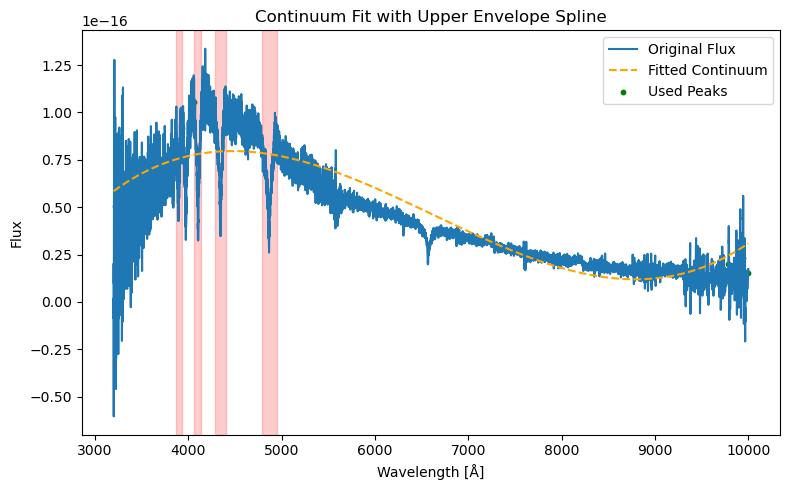

Fit center = 4343.1613 ± 0.7519 Å


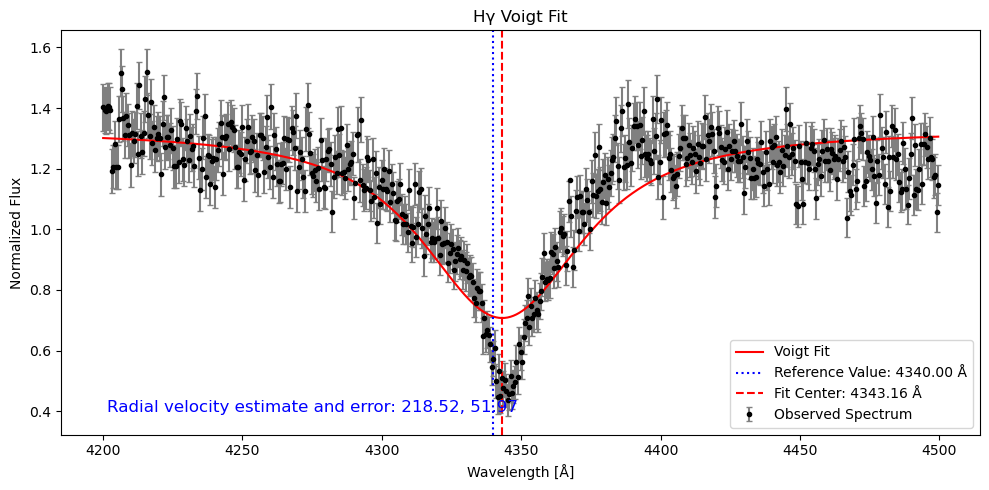

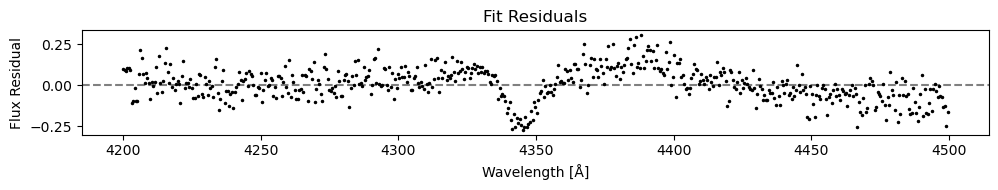

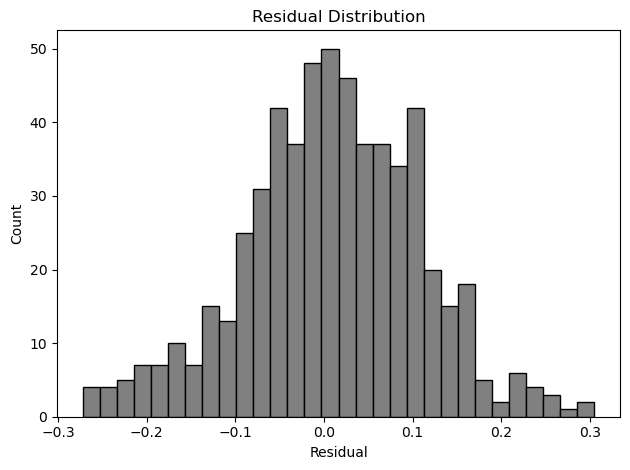

Fit center = 4344.4779 ± 0.7398 Å
Fit center = 4342.8973 ± 0.7886 Å
Fit center = 4344.3803 ± 0.7492 Å
Fit center = 4342.8229 ± 0.7377 Å
Fit center = 4343.9712 ± 0.7760 Å
Fit center = 4342.1004 ± 0.7281 Å
Fit center = 4343.8280 ± 0.9541 Å
Fit center = 4341.6164 ± 1.0164 Å
Fit center = 4343.1800 ± 0.7473 Å
Fit center = 4341.6266 ± 0.7352 Å
Fit center = 4342.7032 ± 0.7315 Å
Fit center = 4341.5008 ± 0.6921 Å
Fit center = 4343.1149 ± 0.7325 Å
Fit center = 4340.5144 ± 0.7094 Å
Fit center = 4342.2877 ± 0.7040 Å
Fit center = 4340.7595 ± 0.7307 Å
Fit center = 4343.0581 ± 0.7151 Å
Fit center = 4341.5871 ± 0.7091 Å
Fit center = 4343.4086 ± 0.7419 Å
Fit center = 4341.7644 ± 0.7365 Å


In [5]:
### ARRAY FN ###
ds = xr.open_dataset("D:/Pavlicek, Emma/WD1202/WD1202_spectra.nc", engine="h5netcdf")
wavelength = ds['wavelength'].values
flux_array = ds['flux_calibrated'].values  # shape: (time, wavelength)

centroids = []
velocities = []
centroid_errors = []
velocity_errors = []

for i in range(flux_array.shape[0]):
    flux = flux_array[i, :]
    flux_err = ds['flux_calibrated_error'].values[i, :]
    
    # Set plot=True every n indices
    should_plot = (i % 21 == 0)
    center, center_err, velocity, velocity_err = fit_centroid(
        wavelength, flux, flux_error=flux_err, lambda_0=4340, w1=4200, w2=4500, line_name="Hγ", plot=should_plot
        )
    
    centroids.append(center)
    centroid_errors.append(center_err)
    velocity_errors.append(velocity_err)
    velocities.append(velocity)



# Convert to xarrays
vel_da = xr.DataArray(
    data=velocities,
    coords={"time": ds.time},
    dims=["time"],
    name="radial_velocity",
    attrs={"units": "km/s", "description": "Radial velocity from Hα centroid"}
)

center_da = xr.DataArray(
    data=centroids,
    coords={"time": ds.time},
    dims=["time"],
    name="Hα_centroid",
    attrs={"units": "Angstrom", "description": "Fitted centroid of Hα absorption"}
)

centroid_err_da = xr.DataArray(
    data=centroid_errors,
    coords={"time": ds.time},
    dims=["time"],
    name="Hα_centroid_error",
    attrs={"units": "Angstrom", "description": "Uncertainty in fitted Hα centroid"}
)

vel_err_da = xr.DataArray(
    data=velocity_errors,
    coords={"time": ds.time},
    dims=["time"],
    name="radial_velocity_error",
    attrs={"units": "km/s", "description": "Uncertainty in radial velocity from Hα centroid"}
)

Hα_fit_result_ds = xr.Dataset({
    "radial_velocity": vel_da,
    "radial_velocity_error": vel_err_da,
    "Hα_centroid": center_da,
    "Hα_centroid_error": centroid_err_da
})

#print(Hα_fit_result_ds)


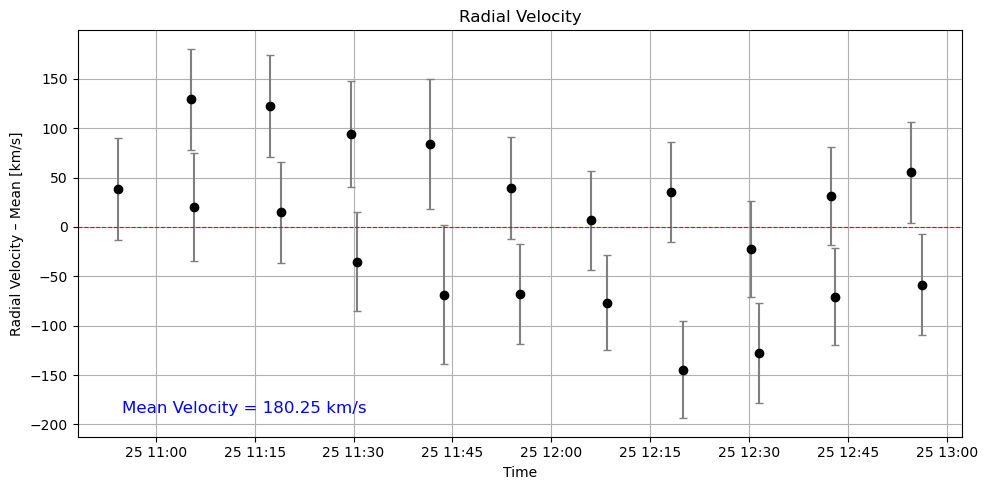

In [6]:
###MEAN V PLOT###
# Extract from dataset
v = Hα_fit_result_ds['radial_velocity'].values
v_err = Hα_fit_result_ds['radial_velocity_error'].values
time = Hα_fit_result_ds['time'].values


# Compute velocity (mean)
v_mean = np.nanmean(v)

# Compute residuals
v_resid = v - v_mean

# Plot
plt.figure(figsize=(10, 5))
plt.errorbar(time, v_resid, yerr=v_err, fmt='o', color='black', ecolor='gray', capsize=3)

plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
plt.title("Radial Velocity")
plt.xlabel("Time")
plt.ylabel("Radial Velocity – Mean [km/s]")
plt.grid(True)

plt.text(0.05, 0.05, f"Mean Velocity = {v_mean:.2f} km/s", fontsize=12, color='blue', horizontalalignment="left", verticalalignment="bottom", transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()




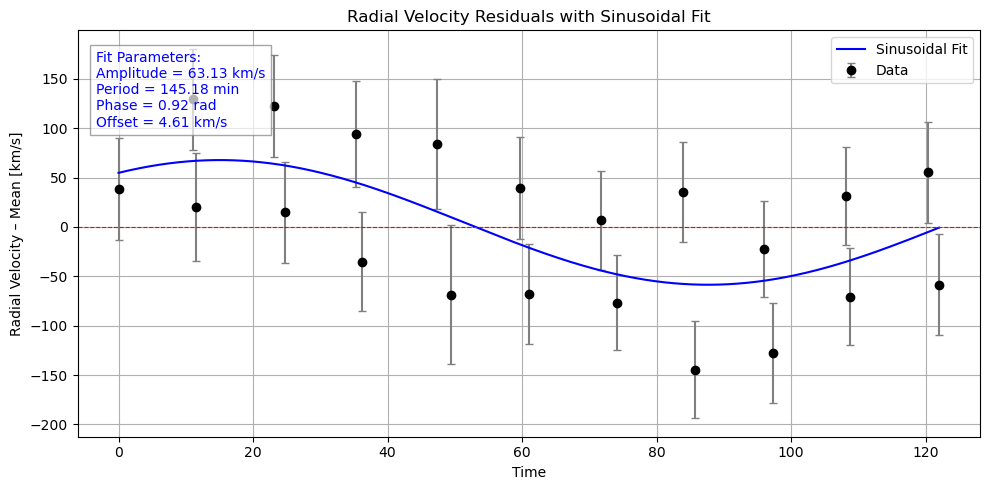

Amplitude = 63.13 ± 15.50 km/s
Frequency = 0.00689 ± 0.00140 cycles/min
Period = 145.18 ± 29.51 min
Phase = 0.92 ± 0.72 rad
Offset = 4.61 ± 13.43 km/s


In [7]:
###FIT LEVEL 2###
# --- Data extraction ---
v = Hα_fit_result_ds['radial_velocity'].values
v_err = Hα_fit_result_ds['radial_velocity_error'].values
time = Hα_fit_result_ds['time'].values

# Remove NaNs
mask = ~np.isnan(v) & ~np.isnan(v_err) & ~np.isnan(time)
time = time[mask]
v = v[mask]
v_err = v_err[mask]

# --- Residuals ---
v_mean = np.mean(v)
v_resid = v - v_mean

# --- Sinusoid model ---
def sinusoid(t, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) + C

time0 = time[0]
time = (time - time[0]) / np.timedelta64(1, 'm')  # minutes since first OBS
# --- Initial guess (tweak if needed) ---
A_guess = 10  # amplitude in km/s
f_guess = 1 / (time.max() - time.min())  # one cycle across full range
phi_guess = 0
C_guess = 0

p0 = [A_guess, f_guess, phi_guess, C_guess]

# --- Fit ---
popt, pcov = curve_fit(sinusoid, time, v_resid, sigma=v_err, absolute_sigma=True, p0=p0)
A_fit, f_fit, phi_fit, C_fit = popt

# --- Model curve ---
time_fit = np.linspace(time.min(), time.max(), 1000)
v_fit = sinusoid(time_fit, *popt)

perr = np.sqrt(np.diag(pcov))  # uncertainties
A_err, f_err, phi_err, C_err = perr

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.errorbar(time, v_resid, yerr=v_err, fmt='o', color='black', ecolor='gray', capsize=3, label='Data')
plt.plot(time_fit, v_fit, color='blue', label='Sinusoidal Fit')
plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
plt.title("Radial Velocity Residuals with Sinusoidal Fit")
plt.xlabel("Time")
plt.ylabel("Radial Velocity – Mean [km/s]")
# Annotate fit parameters on plot
fit_label = (
    f"Fit Parameters:\n"
    f"Amplitude = {A_fit:.2f} km/s\n"
    f"Period = {1/f_fit:.2f} min\n"
    f"Phase = {phi_fit:.2f} rad\n"
    f"Offset = {C_fit:.2f} km/s"
)

# Position it in axes coordinates (lower left corner)
plt.text(0.02, 0.95, fit_label, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', color='blue',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Print fitted parameters ---
print(f"Amplitude = {A_fit:.2f} ± {A_err:.2f} km/s")
print(f"Frequency = {f_fit:.5f} ± {f_err:.5f} cycles/min")
print(f"Period = {1/f_fit:.2f} ± {(f_err / f_fit**2):.2f} min")
print(f"Phase = {phi_fit:.2f} ± {phi_err:.2f} rad")
print(f"Offset = {C_fit:.2f} ± {C_err:.2f} km/s")



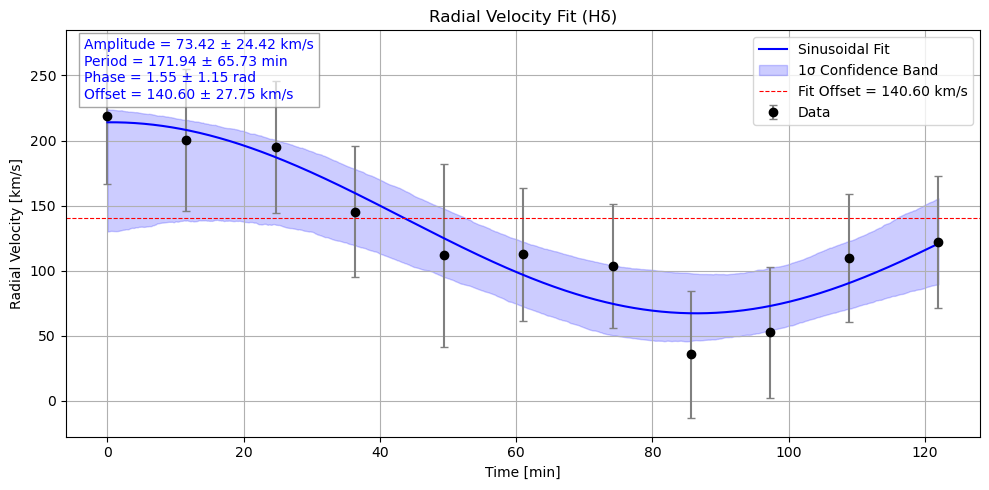

In [8]:
###FIT LEVEL 2###
# --- Data extraction ---
v = Hα_fit_result_ds['radial_velocity'].values
v_err = Hα_fit_result_ds['radial_velocity_error'].values
time = Hα_fit_result_ds['time'].values

# Remove NaNs
# Remove NaNs
mask = ~np.isnan(v) & ~np.isnan(v_err) & ~np.isnan(time)
time = time[mask]
v = v[mask]
v_err = v_err[mask]

# Keep only even indices
time = time[::2]
v = v[::2]
v_err = v_err[::2]


# Convert time to minutes since first observation
time0 = time[0]
time = (time - time0) / np.timedelta64(1, 'm')  # now in minutes

# Define sinusoid model: v(t) = A * sin(2π f t + phi) + C
def sinusoid(t, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) + C

# Initial guess
A_guess = (np.nanmax(v) - np.nanmin(v)) / 2
f_guess = 1 / (time.max() - time.min())  # one full cycle
phi_guess = 0
C_guess = np.mean(v)

p0 = [A_guess, f_guess, phi_guess, C_guess]

# Fit to raw velocities
popt, pcov = curve_fit(sinusoid, time, v, sigma=v_err, absolute_sigma=True, p0=p0)
A_fit, f_fit, phi_fit, C_fit = popt
perr = np.sqrt(np.diag(pcov))
A_err, f_err, phi_err, C_err = perr

# Compute best-fit curve
time_fit = np.linspace(time.min(), time.max(), 1000)
v_fit = sinusoid(time_fit, *popt)

# Monte Carlo uncertainty band
n_samples = 1000
samples = np.random.multivariate_normal(popt, pcov, size=n_samples)
v_samples = np.array([sinusoid(time_fit, *s) for s in samples])
v_lower = np.percentile(v_samples, 16, axis=0)
v_upper = np.percentile(v_samples, 84, axis=0)

# Plot
plt.figure(figsize=(10, 5))
plt.errorbar(time, v, yerr=v_err, fmt='o', color='black', ecolor='gray', capsize=3, label='Data')
plt.plot(time_fit, v_fit, color='blue', label='Sinusoidal Fit')
plt.fill_between(time_fit, v_lower, v_upper, color='blue', alpha=0.2, label='1σ Confidence Band')
plt.title("Radial Velocity Fit (Hδ)")
plt.xlabel("Time [min]")
plt.ylabel("Radial Velocity [km/s]")
plt.axhline(C_fit, color='red', linestyle='--', linewidth=0.8, label=f'Fit Offset = {C_fit:.2f} km/s')
plt.legend()
plt.grid(True)

# Add fit parameters to plot
fit_label = (
    f"Amplitude = {A_fit:.2f} ± {A_err:.2f} km/s\n"
    f"Period = {1/f_fit:.2f} ± {(f_err / f_fit**2):.2f} min\n"
    f"Phase = {phi_fit:.2f} ± {phi_err:.2f} rad\n"
    f"Offset = {C_fit:.2f} ± {C_err:.2f} km/s"
)
plt.text(0.02, 0.98, fit_label, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', color='blue',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

plt.tight_layout()
plt.show()


In [42]:
def save_to_h5netcdf(dataset, output_path):
    """
    Save an xarray Dataset or DataArray to a NetCDF file using the h5netcdf engine.

    Input:
        dataset (xr.Dataset or xr.DataArray): The xarray object to save.
        output_path (str): File path to save the NetCDF file.

    Returns:
        str: The file path where the data was saved.
    """
    dataset.to_netcdf(output_path, engine="h5netcdf")
    return output_path

In [44]:
save_to_h5netcdf(Ha_fit_result_ds, "Ha_fits.h5")

'Ha_fits.h5'

In [ ]:
ds_fit = ds.copy()
ds_fit['radial_velocity'] = vel_da
ds_fit['Ha_centroid'] = center_da